# Poisson Goals Model for Football Match Outcomes

This notebook builds a **Poisson goals model** to estimate expected goals for each team in a match, then converts those expectations into **Win / Draw / Loss** probabilities.

**Key idea**
- Model goals scored as Poisson random variables.
- Learn team **attack** and **defense** strengths (plus a **home advantage** term).
- Use the predicted expected goals (λ) to compute outcome probabilities.

---

## Dataset
The notebook expects `data/matches.csv` produced by the repository pipeline.


## 1) Environment setup (Colab / local)


In [37]:
!git clone https://github.com/eamtcPROG/AIA.git
%cd AIA

Cloning into 'AIA'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 120 (delta 43), reused 92 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (120/120), 3.71 MiB | 8.65 MiB/s, done.
Resolving deltas: 100% (43/43), done.
/content/AIA/AIA/AIA


## 2) Install dependencies


In [38]:
!python3 -m pip install --upgrade -q pip
!python3 -m pip install -q pandas numpy matplotlib scikit-learn statsmodels scipy


## 3) Imports and configuration


In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import poisson

# Column mapping (matches.csv schema)
home_team_col = "homeTeam_name"
away_team_col = "awayTeam_name"
home_goals_col = "score_fullTime_home"
away_goals_col = "score_fullTime_away"
date_col = "utcDate"

comp_id_col = "competition_id"
comp_name_col = "competition_name"
comp_code_col = "competition_code"

season_start_col = "season_startDate"
season_end_col = "season_endDate"

status_col = "status"


## 4) Load matches.csv


In [40]:
matches_path = os.path.join("data", "matches.csv")

if not os.path.exists(matches_path):
    raise FileNotFoundError(
        f"{matches_path} not found.\n"
        "Generate it first using the repo pipeline (e.g. python3 code/parser.py) "
        "and ensure the file is written to data/matches.csv."
    )

matches = pd.read_csv(matches_path)
print("Loaded:", matches_path)
print("Shape:", matches.shape)
display(matches.head())


Loaded: data/matches.csv
Shape: (1140, 46)


,area_name,attendance,awayTeam_crest,awayTeam_id,awayTeam_name,awayTeam_shortName,awayTeam_tla,bookings_count,competition_code,competition_id,...,score_penalties_home,score_regularTime_away,score_regularTime_home,score_winner,season_endDate,season_startDate,stage,status,utcDate,venue
0,Spain,NaN,https://crests.football-data.org/87.png,87,Rayo Vallecano de Madrid,Rayo Vallecano,RAY,0,PD,2014,...,NaN,NaN,NaN,AWAY_TEAM,2024-05-26,2023-08-13,REGULAR_SEASON,FINISHED,2023-08-11T17:30:00Z,NaN
1,Spain,NaN,https://crests.football-data.org/95.png,95,Valencia CF,Valencia,VAL,0,PD,2014,...,NaN,NaN,NaN,AWAY_TEAM,2024-05-26,2023-08-13,REGULAR_SEASON,FINISHED,2023-08-11T20:00:00Z,NaN
2,Spain,NaN,https://crests.football-data.org/298.png,298,Girona FC,Girona,GIR,0,PD,2014,...,NaN,NaN,NaN,DRAW,2024-05-26,2023-08-13,REGULAR_SEASON,FINISHED,2023-08-12T15:00:00Z,NaN
3,Spain,NaN,https://crests.football-data.org/89.png,89,RCD Mallorca,Mallorca,MAL,0,PD,2014,...,NaN,NaN,NaN,DRAW,2024-05-26,2023-08-13,REGULAR_SEASON,FINISHED,2023-08-12T17:30:00Z,NaN
4,Spain,NaN,https://crests.football-data.org/86.png,86,Real Madrid CF,Real Madrid,RMA,0,PD,2014,...,NaN,NaN,NaN,AWAY_TEAM,2024-05-26,2023-08-13,REGULAR_SEASON,FINISHED,2023-08-12T19:30:00Z,NaN


## 5) Data cleaning and preparation


In [41]:
df = matches.copy()

# Parse dates
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df[season_start_col] = pd.to_datetime(df[season_start_col], errors="coerce")
df[season_end_col] = pd.to_datetime(df[season_end_col], errors="coerce")

# Keep finished matches if status is available
if status_col in df.columns:
    df = df[df[status_col] == "FINISHED"].copy()

# Require full-time goals and team names
df = df.dropna(subset=[home_team_col, away_team_col, home_goals_col, away_goals_col])

# Ensure integer goals
df[home_goals_col] = df[home_goals_col].astype(int)
df[away_goals_col] = df[away_goals_col].astype(int)

# Keep non-negative scores
df = df[(df[home_goals_col] >= 0) & (df[away_goals_col] >= 0)].copy()

print("Usable matches:", df.shape)
display(df[[comp_name_col, comp_code_col, home_team_col, away_team_col, home_goals_col, away_goals_col, date_col]].head())


Usable matches: (944, 46)


,competition_name,competition_code,homeTeam_name,awayTeam_name,score_fullTime_home,score_fullTime_away,utcDate
0,Primera Division,PD,UD Almería,Rayo Vallecano de Madrid,0,2,2023-08-11 17:30:00+00:00
1,Primera Division,PD,Sevilla FC,Valencia CF,1,2,2023-08-11 20:00:00+00:00
2,Primera Division,PD,Real Sociedad de Fútbol,Girona FC,1,1,2023-08-12 15:00:00+00:00
3,Primera Division,PD,UD Las Palmas,RCD Mallorca,1,1,2023-08-12 17:30:00+00:00
4,Primera Division,PD,Athletic Club,Real Madrid CF,0,2,2023-08-12 19:30:00+00:00


## 6) Exploratory summary (quick visuals)

These plots provide a compact overview:
- match volume by competition
- distribution of goals (home vs away)
- average home vs away goals (home advantage indication)


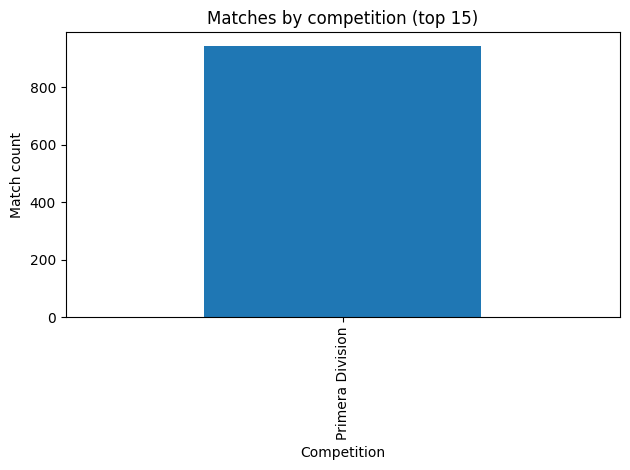

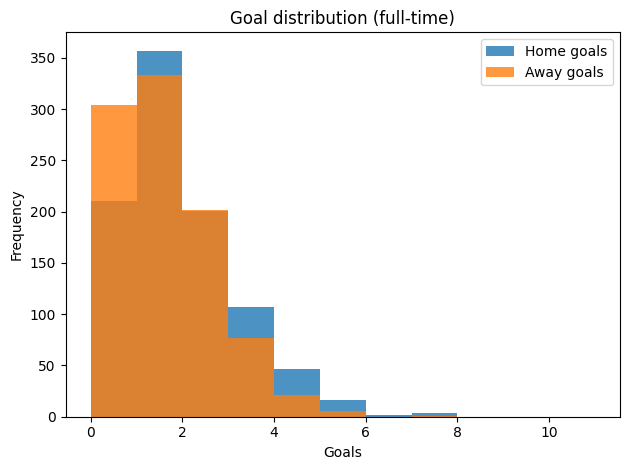

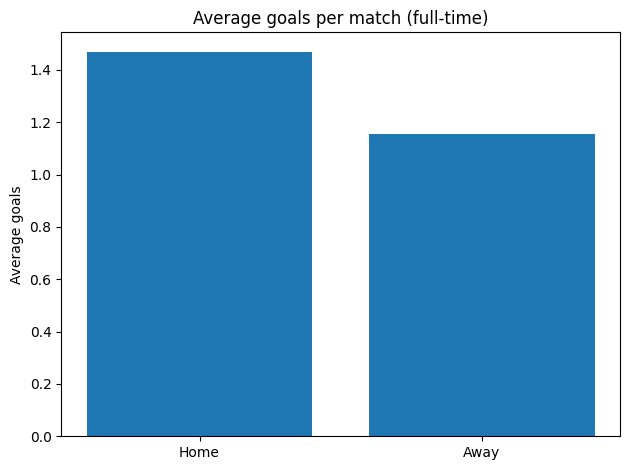

Average home goals: 1.470
Average away goals: 1.154


In [42]:
# Matches by competition (top 15)
top_comp = df[comp_name_col].value_counts().head(15)

plt.figure()
top_comp.plot(kind="bar")
plt.title("Matches by competition (top 15)")
plt.xlabel("Competition")
plt.ylabel("Match count")
plt.tight_layout()
plt.show()

# Goal distributions
plt.figure()
plt.hist(df[home_goals_col].values, bins=range(0, max(df[home_goals_col].max(), 10) + 2), alpha=0.8, label="Home goals")
plt.hist(df[away_goals_col].values, bins=range(0, max(df[away_goals_col].max(), 10) + 2), alpha=0.8, label="Away goals")
plt.title("Goal distribution (full-time)")
plt.xlabel("Goals")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Average goals: home vs away
avg_home = df[home_goals_col].mean()
avg_away = df[away_goals_col].mean()

plt.figure()
plt.bar(["Home", "Away"], [avg_home, avg_away])
plt.title("Average goals per match (full-time)")
plt.ylabel("Average goals")
plt.tight_layout()
plt.show()

print(f"Average home goals: {avg_home:.3f}")
print(f"Average away goals: {avg_away:.3f}")


## 7) Competition selection

The dataset can contain multiple competitions. For stable training and evaluation, the notebook selects a **single competition**.

**Default behavior**
- Uses the most frequent competition in the CSV.

**Manual option**
- Set `COMPETITION_CODE` to one of the codes present in the dataset (examples: `PL`, `PD`, `SA`, `BL1`, `FL1`, `CL`, etc.).


In [43]:
# Default: pick the most frequent competition_code available
available_codes = df[comp_code_col].dropna().astype(str)
COMPETITION_CODE = available_codes.value_counts().idxmax()

# Manual option (uncomment and set a code from the list below)
# COMPETITION_CODE = "PD"

print("Competition codes available (top 15):")
display(available_codes.value_counts().head(15))

print("Using COMPETITION_CODE =", COMPETITION_CODE)
df = df[df[comp_code_col].astype(str) == str(COMPETITION_CODE)].copy()
print("After filter:", df.shape)


Competition codes available (top 15):


,count
competition_code,
PD,944


Using COMPETITION_CODE = PD
After filter: (944, 46)


## 8) Train / test split

**Preferred split**
- Use the most recent season as the test set, and older seasons as training.

**Fallback**
- If season fields are missing, split chronologically by match date.


In [44]:
if df[season_start_col].notna().any():
    seasons = np.sort(df[season_start_col].dropna().unique())
    if len(seasons) >= 2:
        test_season = seasons[-1]
        train_df = df[df[season_start_col] < test_season].copy()
        test_df  = df[df[season_start_col] == test_season].copy()

        print("Train seasons:", seasons[:-1])
        print("Test season:", test_season)
        print("Train:", train_df.shape, "Test:", test_df.shape)
    else:
        train_df = None
        test_df = None
else:
    train_df = None
    test_df = None

if train_df is None or test_df is None or len(test_df) == 0:
    df = df.sort_values(date_col).reset_index(drop=True)
    split_idx = int(len(df) * 0.8)
    train_df = df.iloc[:split_idx].copy()
    test_df  = df.iloc[split_idx:].copy()

    print("Chronological time split used:")
    print("Train:", train_df.shape, "Test:", test_df.shape)
    print("Train dates:", train_df[date_col].min(), "→", train_df[date_col].max())
    print("Test  dates:", test_df[date_col].min(),  "→", test_df[date_col].max())


Train seasons: ['2023-08-13T00:00:00.000000000' '2024-08-18T00:00:00.000000000']
Test season: 2025-08-17T00:00:00.000000000
Train: (760, 46) Test: (184, 46)


## 9) Safety filter: unseen teams in test set

If a team appears only in the test period (e.g., promotions), categorical models cannot estimate parameters for that team.
Those matches are removed from the test set to keep predictions valid.


In [45]:
train_teams = set(train_df[home_team_col]).union(set(train_df[away_team_col]))
mask_seen = test_df[home_team_col].isin(train_teams) & test_df[away_team_col].isin(train_teams)

dropped = int((~mask_seen).sum())
print("Test matches removed (unseen teams):", dropped)

test_df = test_df.loc[mask_seen].copy()
print("Final test size:", test_df.shape)


Test matches removed (unseen teams): 51
Final test size: (133, 46)


## 10) Poisson goals model (long format)

Each match is transformed into **two observations**:
- Home team's goals vs opponent (`home=1`)
- Away team's goals vs opponent (`home=0`)

Model:
\[
\text{goals} \sim \text{Poisson}(\lambda), \quad \log(\lambda)=\beta_0 + \beta_{home}\cdot home + \text{Attack(team)} + \text{Defense(opponent)}
\]

Implementation uses:
`goals ~ home + C(team) + C(opponent)`


In [46]:
def to_long_format(matches_df: pd.DataFrame) -> pd.DataFrame:
    home_rows = pd.DataFrame({
        "goals": matches_df[home_goals_col].values,
        "team": matches_df[home_team_col].values,
        "opponent": matches_df[away_team_col].values,
        "home": 1,
    })
    away_rows = pd.DataFrame({
        "goals": matches_df[away_goals_col].values,
        "team": matches_df[away_team_col].values,
        "opponent": matches_df[home_team_col].values,
        "home": 0,
    })
    return pd.concat([home_rows, away_rows], ignore_index=True)

train_long = to_long_format(train_df)
display(train_long.head())


,goals,team,opponent,home
0,0,UD Almería,Rayo Vallecano de Madrid,1
1,1,Sevilla FC,Valencia CF,1
2,1,Real Sociedad de Fútbol,Girona FC,1
3,1,UD Las Palmas,RCD Mallorca,1
4,0,Athletic Club,Real Madrid CF,1


## 11) Fit the Poisson regression (GLM)


In [47]:
model = smf.glm(
    formula="goals ~ home + C(team) + C(opponent)",
    data=train_long,
    family=sm.families.Poisson()
).fit()

print(model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                 1520
Model:                            GLM   Df Residuals:                     1474
Model Family:                 Poisson   Df Model:                           45
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2090.7
Date:                Thu, 22 Jan 2026   Deviance:                       1522.4
Time:                        15:05:26   Pearson chi2:                 1.33e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1969
Covariance Type:            nonrobust                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

## 12) Model diagnostics (visual)

- Estimated home advantage term
- Top coefficients by absolute value (compact overview)


Home coefficient (log scale): 0.2330490803036119
Home multiplier exp(coef): 1.262443438914026


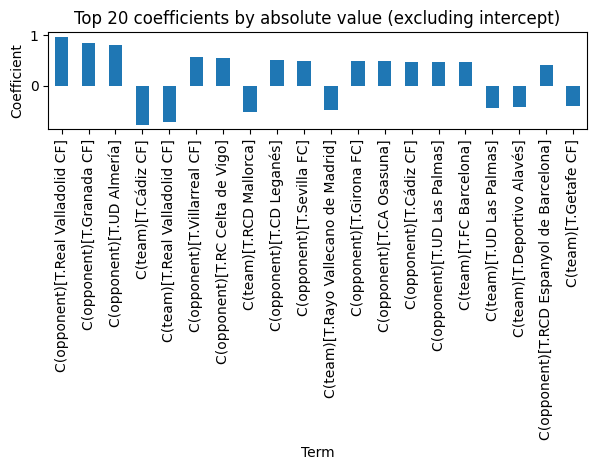

In [48]:
# Home advantage coefficient (log scale). exp(coef) gives multiplicative effect on expected goals.
if "home" in model.params.index:
    home_coef = float(model.params["home"])
    print("Home coefficient (log scale):", home_coef)
    print("Home multiplier exp(coef):", float(np.exp(home_coef)))

# Plot top absolute coefficients (excluding the intercept)
params = model.params.drop(labels=["Intercept"], errors="ignore").copy()
topk = params.reindex(params.abs().sort_values(ascending=False).head(20).index)

plt.figure()
topk.plot(kind="bar")
plt.title("Top 20 coefficients by absolute value (excluding intercept)")
plt.xlabel("Term")
plt.ylabel("Coefficient")
plt.tight_layout()
plt.show()


## 13) Predict expected goals (λ) per match

Two predictions per fixture:
- λ_home: expected home goals
- λ_away: expected away goals


In [49]:
def predict_lambdas_for_match(home_team: str, away_team: str) -> tuple[float, float]:
    X_home = pd.DataFrame([{"team": home_team, "opponent": away_team, "home": 1}])
    X_away = pd.DataFrame([{"team": away_team, "opponent": home_team, "home": 0}])
    lam_home = float(model.predict(X_home)[0])
    lam_away = float(model.predict(X_away)[0])
    return lam_home, lam_away

test_pred = test_df.copy().reset_index(drop=True)
lambdas = test_pred.apply(lambda r: predict_lambdas_for_match(r[home_team_col], r[away_team_col]), axis=1)

test_pred["lambda_home"] = [x[0] for x in lambdas]
test_pred["lambda_away"] = [x[1] for x in lambdas]

display(test_pred[[home_team_col, away_team_col, home_goals_col, away_goals_col, "lambda_home", "lambda_away"]].head())


,homeTeam_name,awayTeam_name,score_fullTime_home,score_fullTime_away,lambda_home,lambda_away
0,Girona FC,Rayo Vallecano de Madrid,1,3,1.743804,0.874219
1,RCD Mallorca,FC Barcelona,0,3,0.860418,1.811663
2,Valencia CF,Real Sociedad de Fútbol,1,1,1.041057,0.975518
3,RC Celta de Vigo,Getafe CF,0,2,1.428844,1.008131
4,Athletic Club,Sevilla FC,3,2,1.802473,0.699922


## 14) Convert λ to outcome probabilities (H / D / A)

Assumption:
- Home and away goals are independent Poisson variables.

Outcome probabilities are computed from the scoreline probability matrix up to `max_goals`.


In [50]:
def outcome_from_goals(hg: int, ag: int) -> str:
    if hg > ag:
        return "H"
    if hg < ag:
        return "A"
    return "D"

def outcome_probs_from_lambdas(lh: float, la: float, max_goals: int = 10):
    home_p = poisson.pmf(np.arange(max_goals + 1), mu=lh)
    away_p = poisson.pmf(np.arange(max_goals + 1), mu=la)
    mat = np.outer(home_p, away_p)

    p_home = np.tril(mat, k=-1).sum()
    p_draw = np.trace(mat)
    p_away = np.triu(mat, k=1).sum()

    i, j = np.unravel_index(mat.argmax(), mat.shape)
    return {
        "P(H)": float(p_home),
        "P(D)": float(p_draw),
        "P(A)": float(p_away),
        "most_likely_score": f"{i}-{j}",
        "most_likely_score_prob": float(mat[i, j]),
    }

probs = test_pred.apply(
    lambda r: outcome_probs_from_lambdas(r["lambda_home"], r["lambda_away"], max_goals=10),
    axis=1
)
probs_df = pd.DataFrame(list(probs))

test_pred = pd.concat([test_pred, probs_df], axis=1)
test_pred["true_outcome"] = test_pred.apply(
    lambda r: outcome_from_goals(r[home_goals_col], r[away_goals_col]),
    axis=1
)

# Base prediction: argmax over probabilities
base_pred = test_pred[["P(H)", "P(D)", "P(A)"]].idxmax(axis=1).map({"P(H)":"H", "P(D)":"D", "P(A)":"A"})

# Draw-aware rule: predict Draw if P(D) is close to the best probability
delta = 0.05  # values like 0.03–0.08 depending on how many draws you want predicted
best = test_pred[["P(H)", "P(D)", "P(A)"]].max(axis=1)

test_pred["pred_outcome"] = np.where(
    test_pred["P(D)"] >= best - delta,
    "D",
    base_pred
)

display_cols = [comp_name_col, home_team_col, away_team_col,
                home_goals_col, away_goals_col, "lambda_home", "lambda_away",
                "P(H)", "P(D)", "P(A)", "pred_outcome", "true_outcome", "most_likely_score"]
display(test_pred[display_cols].head(12))


,competition_name,homeTeam_name,awayTeam_name,score_fullTime_home,score_fullTime_away,lambda_home,lambda_away,P(H),P(D),P(A),pred_outcome,true_outcome,most_likely_score
0,Primera Division,Girona FC,Rayo Vallecano de Madrid,1,3,1.743804,0.874219,0.579514,0.234441,0.186043,H,A,1-0
1,Primera Division,RCD Mallorca,FC Barcelona,0,3,0.860418,1.811663,0.174516,0.226839,0.598642,A,A,0-1
2,Primera Division,Valencia CF,Real Sociedad de Fútbol,1,1,1.041057,0.975518,0.363730,0.306745,0.329526,H,D,1-0
3,Primera Division,RC Celta de Vigo,Getafe CF,0,2,1.428844,1.008131,0.467257,0.266658,0.266085,H,A,1-1
4,Primera Division,Athletic Club,Sevilla FC,3,2,1.802473,0.699922,0.637840,0.222729,0.139428,H,H,1-0
5,Primera Division,RCD Espanyol de Barcelona,Club Atlético de Madrid,2,1,0.881761,1.603048,0.206553,0.249924,0.543523,A,H,0-1
6,Primera Division,Real Madrid CF,CA Osasuna,1,0,2.566047,0.719791,0.771880,0.145772,0.082271,H,H,2-0
7,Primera Division,Real Betis Balompié,Deportivo Alavés,1,0,1.428239,0.817925,0.514409,0.270545,0.215045,H,H,1-0
8,Primera Division,RCD Mallorca,RC Celta de Vigo,1,1,1.135578,1.066433,0.371929,0.290928,0.337143,H,D,1-1
9,Primera Division,CA Osasuna,Valencia CF,1,0,1.348186,1.052220,0.435098,0.272808,0.292094,H,H,1-1


## 15) Evaluation

- Accuracy (label prediction)
- Confusion matrix
- Classification report
- Log loss (probability quality)


In [51]:
y_true = test_pred["true_outcome"]
y_pred = test_pred["pred_outcome"]

print("Accuracy:", accuracy_score(y_true, y_pred))

labels = ["H", "D", "A"]
cm = confusion_matrix(y_true, y_pred, labels=labels)
print("\nConfusion matrix (rows=true, cols=pred) [H, D, A]:\n", cm)

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, labels=labels))

proba = test_pred[["P(H)", "P(D)", "P(A)"]].to_numpy()
y_true_idx = y_true.map({"H":0, "D":1, "A":2}).to_numpy()
print("Log loss:", log_loss(y_true_idx, proba, labels=[0,1,2]))


Accuracy: 0.5413533834586466

Confusion matrix (rows=true, cols=pred) [H, D, A]:
 [[52  4  8]
 [18  1 11]
 [19  1 19]]

Classification report:

              precision    recall  f1-score   support

           H       0.58      0.81      0.68        64
           D       0.17      0.03      0.06        30
           A       0.50      0.49      0.49        39

    accuracy                           0.54       133
   macro avg       0.42      0.44      0.41       133
weighted avg       0.47      0.54      0.48       133

Log loss: 0.9534746064938617


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


## 16) Confusion matrix plot


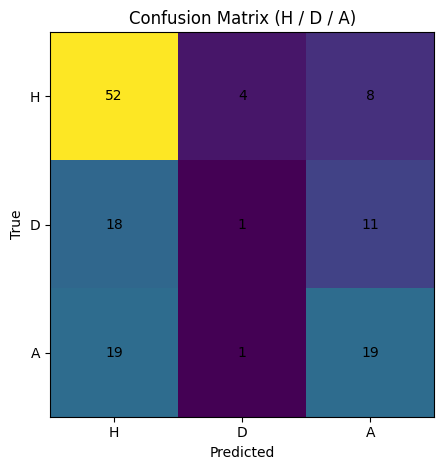

In [52]:
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (H / D / A)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(labels)), labels=labels)
plt.yticks(ticks=np.arange(len(labels)), labels=labels)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.tight_layout()
plt.show()


## 17) Predicted vs actual goals (visual check)

This scatter plot compares:
- predicted λ_home vs actual home goals
- predicted λ_away vs actual away goals


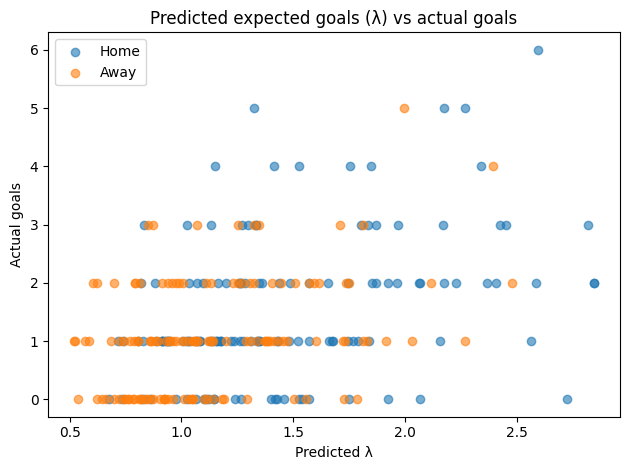

In [53]:
plt.figure()
plt.scatter(test_pred["lambda_home"], test_pred[home_goals_col], alpha=0.6, label="Home")
plt.scatter(test_pred["lambda_away"], test_pred[away_goals_col], alpha=0.6, label="Away")
plt.title("Predicted expected goals (λ) vs actual goals")
plt.xlabel("Predicted λ")
plt.ylabel("Actual goals")
plt.legend()
plt.tight_layout()
plt.show()


## 18) Single-fixture prediction (default example)

The example uses two teams selected from the training set.
To change it, replace `example_home_team` and `example_away_team` with any team names present in the filtered competition.


In [54]:
def predict_fixture(home_team: str, away_team: str, max_goals: int = 10):
    lh, la = predict_lambdas_for_match(home_team, away_team)
    out = outcome_probs_from_lambdas(lh, la, max_goals=max_goals)
    out["home_team"] = home_team
    out["away_team"] = away_team
    out["lambda_home"] = lh
    out["lambda_away"] = la
    return out

example_home_team = train_df[home_team_col].value_counts().idxmax()
example_away_team = train_df[away_team_col].value_counts().index[0]
if example_away_team == example_home_team and len(train_df[away_team_col].value_counts()) > 1:
    example_away_team = train_df[away_team_col].value_counts().index[1]

print("Example fixture:", example_home_team, "vs", example_away_team)
predict_fixture(example_home_team, example_away_team, max_goals=10)


Example fixture: Sevilla FC vs Rayo Vallecano de Madrid


{'P(H)': 0.4389468784451893,
 'P(D)': 0.29402889895836554,
 'P(A)': 0.26702414823323867,
 'most_likely_score': '1-0',
 'most_likely_score_prob': 0.14939749598093136,
 'home_team': 'Sevilla FC',
 'away_team': 'Rayo Vallecano de Madrid',
 'lambda_home': 1.2171070392915906,
 'lambda_away': 0.880514491175587}

## Notes and limitations

- Assumes independence of home and away goals.
- Team strengths are treated as stable over the training period.
- Does not include injuries, red cards, lineups, travel, or betting odds.
- A common extension is time-decay weighting (recent matches count more).
